In [1]:
import uproot
import numpy as np
import awkward as ak
import hist
import matplotlib.pyplot as plt
import mplhep as hep
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from agc_schema import AGCSchema
events = NanoEventsFactory.from_root('root://eospublic.cern.ch//eos/opendata/cms/upload/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/00EFE6B3-01FE-4FBF-ADCB-2921D5903E44_flat.root', schemaclass=AGCSchema, treepath='events').events()

In [2]:
ak.num(events.electron, axis=1)
ak.num(events.muon, axis=-1)
ak.num(events.jet, axis=1)

<Array [4, 5, 4, 5, 9, 4, ... 7, 4, 4, 6, 5, 4] type='325519 * int64'>

In [3]:
events.electron.fields
events.muon.fields
events.jet.fields

['pt',
 'eta',
 'phi',
 'ch',
 'mass',
 'btag',
 'hflav',
 'corrpt',
 'corrptUp',
 'corrptDown',
 'corrptSmearUp',
 'corrptSmearDown',
 'corrmass',
 'corre',
 'corrpx',
 'corrpy',
 'corrpz',
 'energy']

In [4]:
selected_electrons = events.electron[(events.electron.pt > 30) & (abs(events.electron.eta)<2.1) & (events.electron.isTight == True)]
selected_muons = events.muon[(events.muon.pt > 30) & (abs(events.muon.eta)<2.1) & (events.muon.isTight == True)]
selected_jets = events.jet[(events.jet.corrpt > 30) & (abs(events.jet.eta)<2.4)]

In [5]:
ak.num(selected_electrons, axis=1)
ak.num(selected_muons, axis=1)
ak.num(selected_jets, axis=1)

<Array [3, 5, 4, 5, 7, 3, ... 5, 4, 1, 3, 4, 3] type='325519 * int64'>

In [6]:
selected_electrons = events.electron[(events.electron.pt > 30) & (abs(events.electron.eta)<2.1) & (events.electron.isTight == True) & (events.electron.sip3d < 4)]
selected_muons = events.muon[(events.muon.pt > 30) & (abs(events.muon.eta)<2.1) & (events.muon.isTight == True) & (events.muon.sip3d < 4) & (events.muon.pfreliso04DBCorr < 0.15)]

In [7]:
event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)

In [8]:
event_filters = event_filters & (ak.count(selected_jets.corrpt, axis=1) >= 4)

In [9]:
# at least one b-tagged jet ("tag" means score above threshold)
B_TAG_THRESHOLD = 0.8
event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

In [10]:
selected_events = events[event_filters]
selected_electrons = selected_electrons[event_filters]
selected_muons = selected_muons[event_filters]
selected_jets = selected_jets[event_filters]

In [12]:
region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
selected_jets_region = selected_jets[region_filter]

In [13]:
trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
# pick trijet candidate with largest pT and calculate mass of system
trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
observable = ak.flatten(trijet_mass)

In [14]:
histogram = hist.Hist.new.Reg(25, 50, 550, name="observable", label="observable [GeV]").StrCat(["4j1b", "4j2b"], name="region", label="Region").StrCat([], name="process", label="Process", growth=True).StrCat([], name="variation", label="Systematic variation", growth=True).Weight()

In [15]:
histogram.ndim
histogram.axes

(Regular(25, 50, 550, name='observable', label='observable [GeV]'),
 StrCategory(['4j1b', '4j2b'], name='region', label='Region'),
 StrCategory([], growth=True, name='process', label='Process'),
 StrCategory([], growth=True, name='variation', label='Systematic variation'))

In [16]:
histogram.fill(observable=observable, region="4j2b", process="ttbar", variation="nominal", weight=1)

Hist(
  Regular(25, 50, 550, name='observable', label='observable [GeV]'),
  StrCategory(['4j1b', '4j2b'], name='region', label='Region'),
  StrCategory(['ttbar'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=63995, variance=63995) (WeightedSum(value=65595, variance=65595) with flow)

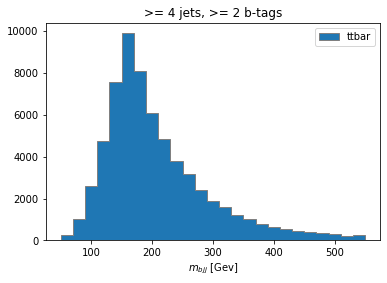

In [17]:
histogram[:,"4j2b","ttbar","nominal"].plot(histtype="fill", linewidth=1, edgecolor="grey", label='ttbar')
plt.legend()
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]");
plt.show()